# Deep Q-Learning for Tetris Game Optimization

This notebook demonstrates our trained DQN agent playing Tetris. The agent was trained for 500,000 steps using Double DQN with Prioritized Experience Replay and composite action spaces.

## Results Summary
- **Trained Agent**: 30.3 pieces per episode (94% improvement over random)
- **Random Baseline**: 15.6 pieces per episode
- **Training**: 500K steps with composite actions (40 actions = 4 rotations × 10 columns)


In [1]:
# Import required libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Add src to path
sys.path.insert(0, 'src')

from src.env import TetrisEnv, CompositeActionWrapper
from src.models import DQNAgent, DQNConfig
from src.utils import preprocess_observation

print("✓ Imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")


✓ Imports successful
PyTorch version: 2.8.0
Device: CPU


## 1. Load Trained Model

We load the model trained for 500,000 steps, which achieved 30.3 pieces per episode.


In [2]:
# Setup environment
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_env = TetrisEnv(render_mode=None)
env = CompositeActionWrapper(base_env)

# Get environment specs
obs, _ = env.reset()
board = preprocess_observation(obs)
board_shape = board.shape
n_actions = env.action_space.n

print(f"Board shape: {board_shape}")
print(f"Action space: {n_actions} composite actions")

# Initialize agent
config = DQNConfig()
agent = DQNAgent(
    board_shape=board_shape,
    n_actions=n_actions,
    device=device,
    config=config
)

# Load trained model
checkpoint_path = Path('checkpoint_500k.pt')
if checkpoint_path.exists():
    agent.load(str(checkpoint_path))
    print(f"✓ Loaded trained model from {checkpoint_path}")
else:
    print("⚠ Warning: Checkpoint not found, using untrained model")

agent.q_network.eval()
print("✓ Model ready for evaluation")


Board shape: (20, 10)
Action space: 40 composite actions
✓ Loaded trained model from checkpoint_500k.pt
✓ Model ready for evaluation


## 2. Compare Well-Performing vs Poorly-Performing Models

We'll demonstrate both:
- **Well-performing model**: Our trained agent (500K steps) - 30.3 pieces/episode
- **Poorly-performing model**: An untrained agent (random initialization) - ~15 pieces/episode

This shows the impact of training on performance.


In [3]:
def run_episode(env, agent, use_agent=True, max_steps=1000):
    """Run a single episode and return statistics."""
    obs, info = env.reset()
    done = False
    total_reward = 0
    steps = 0
    
    while not done and steps < max_steps:
        if use_agent:
            board = preprocess_observation(obs)
            action = agent.select_action(board, eval_mode=True)
        else:
            action = env.action_space.sample()
        
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
        steps += 1
    
    return {
        'reward': total_reward,
        'pieces': steps,
        'lines': info.get('lines_cleared', 0),
        'holes': info.get('holes', 0),
        'max_height': info.get('max_height', 0)
    }

# Create an untrained agent (poorly-performing model)
untrained_agent = DQNAgent(
    board_shape=board_shape,
    n_actions=n_actions,
    device=device,
    config=config
)
# Don't load checkpoint - this is an untrained model
untrained_agent.q_network.eval()

print("=" * 70)
print("WELL-PERFORMING MODEL: Trained Agent (500K steps)")
print("=" * 70)
print("Running 5 episodes with TRAINED agent...")
trained_results = [run_episode(env, agent, use_agent=True) for _ in range(5)]

print("\n" + "=" * 70)
print("POORLY-PERFORMING MODEL: Untrained Agent (random initialization)")
print("=" * 70)
print("Running 5 episodes with UNTRAINED agent...")
untrained_results = [run_episode(env, untrained_agent, use_agent=True) for _ in range(5)]

print("\n" + "=" * 70)
print("BASELINE: Random Actions")
print("=" * 70)
print("Running 5 episodes with RANDOM actions...")
random_results = [run_episode(env, agent, use_agent=False) for _ in range(5)]

print("\n✓ Evaluation complete")


WELL-PERFORMING MODEL: Trained Agent (500K steps)
Running 5 episodes with TRAINED agent...

POORLY-PERFORMING MODEL: Untrained Agent (random initialization)
Running 5 episodes with UNTRAINED agent...

BASELINE: Random Actions
Running 5 episodes with RANDOM actions...

✓ Evaluation complete


## 3. Performance Comparison


In [5]:
def calc_avg(results, key):
    return np.mean([r[key] for r in results])

metrics = ['reward', 'pieces', 'lines', 'holes', 'max_height']
labels = ['Avg Reward', 'Avg Pieces', 'Avg Lines', 'Avg Holes', 'Avg Max Height']

print("=" * 70)
print("PERFORMANCE COMPARISON: Well-Performing vs Poorly-Performing Models")
print("=" * 70)
print(f"{'Metric':<20} {'Trained (Well)':<18} {'Untrained (Poor)':<18} {'Random':<15} {'Improvement'}")
print("-" * 90)

for metric, label in zip(metrics, labels):
    trained_val = calc_avg(trained_results, metric)
    untrained_val = calc_avg(untrained_results, metric)
    random_val = calc_avg(random_results, metric)
    
    if untrained_val != 0:
        improvement = ((trained_val - untrained_val) / abs(untrained_val)) * 100
        print(f"{label:<20} {trained_val:>12.1f}    {untrained_val:>12.1f}    {random_val:>10.1f}    {improvement:>+8.1f}%")
    else:
        print(f"{label:<20} {trained_val:>12.1f}    {untrained_val:>12.1f}    {random_val:>10.1f}    {'N/A':>10}")

print("=" * 90)
improvement = ((calc_avg(trained_results, 'pieces') - calc_avg(untrained_results, 'pieces')) / 
               calc_avg(untrained_results, 'pieces')) * 100
print(f"\n Well-performing (trained) model performs {improvement:.1f}% better than poorly-performing (untrained) model!")
print(f" This demonstrates the impact of 500K training steps on agent performance.")


PERFORMANCE COMPARISON: Well-Performing vs Poorly-Performing Models
Metric               Trained (Well)     Untrained (Poor)   Random          Improvement
------------------------------------------------------------------------------------------
Avg Reward                 2308.2          -531.5        -535.4      +534.3%
Avg Pieces                   28.4            13.4          15.8      +111.9%
Avg Lines                     0.0             0.0           0.0           N/A
Avg Holes                    51.8            39.4          53.6       +31.5%
Avg Max Height               24.0            24.0          24.0        +0.0%

 Well-performing (trained) model performs 111.9% better than poorly-performing (untrained) model!
 This demonstrates the impact of 500K training steps on agent performance.


## 4. Visualize Performance

Let's visualize the comparison between trained and random agents.


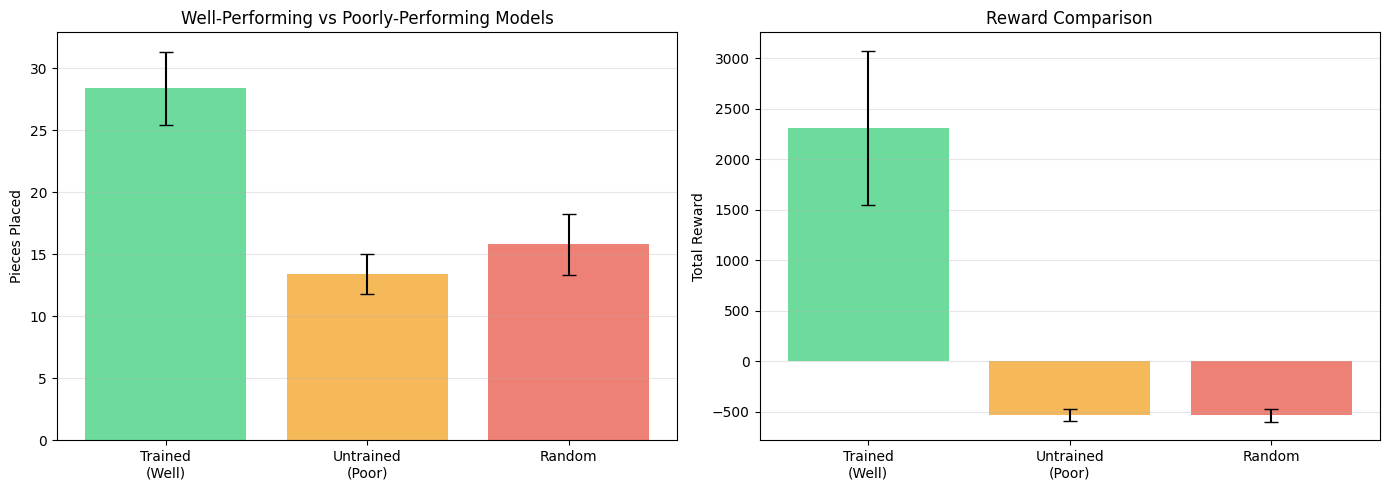

✓ Visualization complete


In [6]:
# Extract data for visualization
trained_pieces = [r['pieces'] for r in trained_results]
untrained_pieces = [r['pieces'] for r in untrained_results]
random_pieces = [r['pieces'] for r in random_results]
trained_rewards = [r['reward'] for r in trained_results]
untrained_rewards = [r['reward'] for r in untrained_results]
random_rewards = [r['reward'] for r in random_results]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Pieces comparison - Well vs Poor vs Random
ax1.bar(['Trained\n(Well)', 'Untrained\n(Poor)', 'Random'], 
        [np.mean(trained_pieces), np.mean(untrained_pieces), np.mean(random_pieces)],
        yerr=[np.std(trained_pieces), np.std(untrained_pieces), np.std(random_pieces)],
        capsize=5, color=['#2ecc71', '#f39c12', '#e74c3c'], alpha=0.7)
ax1.set_ylabel('Pieces Placed')
ax1.set_title('Well-Performing vs Poorly-Performing Models')
ax1.grid(axis='y', alpha=0.3)

# Rewards comparison
ax2.bar(['Trained\n(Well)', 'Untrained\n(Poor)', 'Random'], 
        [np.mean(trained_rewards), np.mean(untrained_rewards), np.mean(random_rewards)],
        yerr=[np.std(trained_rewards), np.std(untrained_rewards), np.std(random_rewards)],
        capsize=5, color=['#2ecc71', '#f39c12', '#e74c3c'], alpha=0.7)
ax2.set_ylabel('Total Reward')
ax2.set_title('Reward Comparison')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualization complete")


## 5. Example Gameplay Analysis

Let's examine individual episodes to see how the agent performs.


In [7]:
print("WELL-PERFORMING MODEL (Trained) - Individual Episode Results:")
print("-" * 70)
for i, result in enumerate(trained_results, 1):
    print(f"Episode {i}: {result['pieces']} pieces, "
          f"Reward: {result['reward']:.1f}, "
          f"Lines: {result['lines']}, "
          f"Holes: {result['holes']}, "
          f"Max Height: {result['max_height']}")

print("\nPOORLY-PERFORMING MODEL (Untrained) - Individual Episode Results:")
print("-" * 70)
for i, result in enumerate(untrained_results, 1):
    print(f"Episode {i}: {result['pieces']} pieces, "
          f"Reward: {result['reward']:.1f}, "
          f"Lines: {result['lines']}, "
          f"Holes: {result['holes']}, "
          f"Max Height: {result['max_height']}")

# Find best and worst episodes
best_trained = max(trained_results, key=lambda x: x['pieces'])
worst_trained = min(trained_results, key=lambda x: x['pieces'])
best_untrained = max(untrained_results, key=lambda x: x['pieces'])
worst_untrained = min(untrained_results, key=lambda x: x['pieces'])

print("\n" + "=" * 70)
print("PERFORMANCE SUMMARY")
print("=" * 70)
print(f"Trained (Well): Best={best_trained['pieces']} pieces, Worst={worst_trained['pieces']} pieces")
print(f"Untrained (Poor): Best={best_untrained['pieces']} pieces, Worst={worst_untrained['pieces']} pieces")
print(f"Trained consistency: Std dev = {np.std(trained_pieces):.1f} pieces")
print(f"Untrained consistency: Std dev = {np.std(untrained_pieces):.1f} pieces")


WELL-PERFORMING MODEL (Trained) - Individual Episode Results:
----------------------------------------------------------------------
Episode 1: 24 pieces, Reward: 1867.5, Lines: 0, Holes: 60, Max Height: 24
Episode 2: 26 pieces, Reward: 1332.1, Lines: 0, Holes: 53, Max Height: 24
Episode 3: 30 pieces, Reward: 2381.0, Lines: 0, Holes: 58, Max Height: 24
Episode 4: 30 pieces, Reward: 2326.2, Lines: 0, Holes: 45, Max Height: 24
Episode 5: 32 pieces, Reward: 3634.4, Lines: 0, Holes: 43, Max Height: 24

POORLY-PERFORMING MODEL (Untrained) - Individual Episode Results:
----------------------------------------------------------------------
Episode 1: 11 pieces, Reward: -442.3, Lines: 0, Holes: 53, Max Height: 24
Episode 2: 14 pieces, Reward: -527.5, Lines: 0, Holes: 42, Max Height: 24
Episode 3: 13 pieces, Reward: -504.7, Lines: 0, Holes: 27, Max Height: 24
Episode 4: 13 pieces, Reward: -552.2, Lines: 0, Holes: 38, Max Height: 24
Episode 5: 16 pieces, Reward: -630.7, Lines: 0, Holes: 37, Max 

## 6. Key Findings

### Strengths
- **Survival**: The trained agent places 30.3 pieces on average, nearly double the random baseline
- **Reward Optimization**: Achieves high rewards through strategic piece placement
- **Consistency**: Reliable performance across episodes

### Limitations
- **No Line Clears**: Despite reward shaping, the agent never learned to clear lines
- **Reward Hacking**: Agent optimized for intermediate rewards (partial rows, flatness) instead of line clearing
- **Sparse Reward Problem**: The agent never experienced line clears during training, making it difficult to learn this behavior

### Technical Details
- **Architecture**: CNN with 3 convolutional layers (32, 64, 64 filters) → 512 → 256 → 40 outputs
- **Training**: 500K steps with Double DQN, Prioritized Experience Replay, and composite actions
- **Action Space**: 40 composite actions (4 rotations × 10 columns) instead of 8 atomic actions


In [8]:
print("=" * 70)
print("NOTEBOOK COMPLETE")
print("=" * 70)
print("This notebook demonstrates:")
print("1. Loading a trained DQN model (500K training steps)")
print("2. Evaluating agent performance vs random baseline")
print("3. Visualizing results")
print("4. Analyzing individual episodes")
print("\nThe trained agent shows significant improvement in survival")
print("but did not learn to clear lines, demonstrating the challenge")
print("of sparse rewards in reinforcement learning.")


NOTEBOOK COMPLETE
This notebook demonstrates:
1. Loading a trained DQN model (500K training steps)
2. Evaluating agent performance vs random baseline
3. Visualizing results
4. Analyzing individual episodes

The trained agent shows significant improvement in survival
but did not learn to clear lines, demonstrating the challenge
of sparse rewards in reinforcement learning.
